In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
folder = './Data'
image_size = (224, 224)
batch_size = 32

In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=5,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 14135 images belonging to 13 classes.
Found 1545 images belonging to 13 classes.


In [5]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [7]:
epochs = 10

history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG16.h5') 

Epoch 1/10
442/442 [==============================] - 134s 296ms/step - loss: 0.2461 - categorical_accuracy: 0.9532 - val_loss: 0.1192 - val_categorical_accuracy: 0.9689
Epoch 2/10
442/442 [==============================] - 129s 292ms/step - loss: 0.0808 - categorical_accuracy: 0.9827 - val_loss: 0.1045 - val_categorical_accuracy: 0.9793
Epoch 3/10
442/442 [==============================] - 127s 287ms/step - loss: 0.0768 - categorical_accuracy: 0.9832 - val_loss: 0.0807 - val_categorical_accuracy: 0.9877
Epoch 4/10
442/442 [==============================] - 124s 280ms/step - loss: 0.0677 - categorical_accuracy: 0.9854 - val_loss: 0.1079 - val_categorical_accuracy: 0.9786
Epoch 5/10
442/442 [==============================] - 126s 284ms/step - loss: 0.0597 - categorical_accuracy: 0.9871 - val_loss: 0.0891 - val_categorical_accuracy: 0.9832
Epoch 6/10
442/442 [==============================] - 124s 280ms/step - loss: 0.0544 - categorical_accuracy: 0.9871 - val_loss: 0.1309 - val_categoric

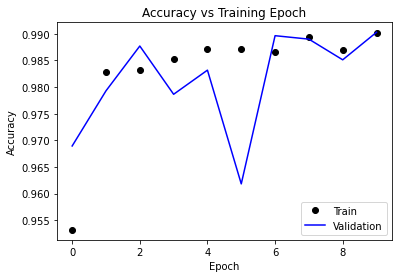

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

C:\Users\David\anaconda3\envs\ensc413-s2022\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


1.9125


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

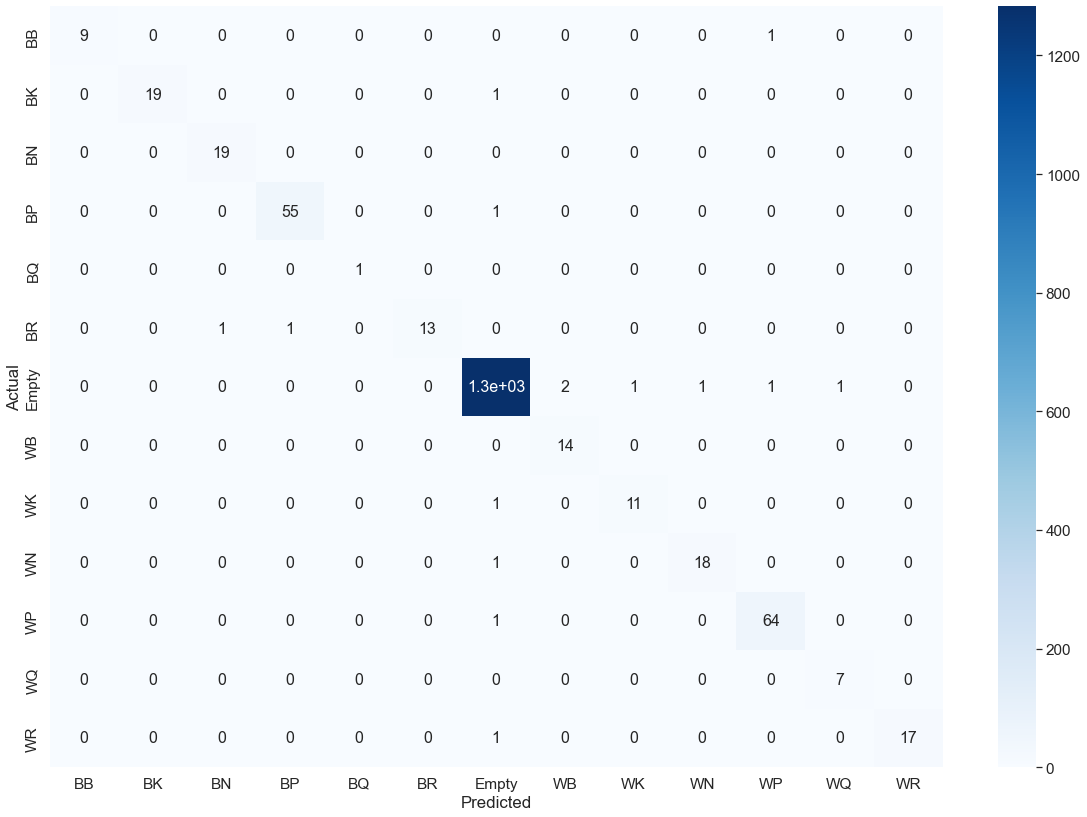

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']

test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [11]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[   9    0    0    0    0    0    0    0    0    0    1    0    0]
 [   0   19    0    0    0    0    1    0    0    0    0    0    0]
 [   0    0   19    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0   55    0    0    1    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0    0    0    0    0]
 [   0    0    1    1    0   13    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1283    2    1    1    1    1    0]
 [   0    0    0    0    0    0    0   14    0    0    0    0    0]
 [   0    0    0    0    0    0    1    0   11    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0   18    0    0    0]
 [   0    0    0    0    0    0    1    0    0    0   64    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    7    0]
 [   0    0    0    0    0    0    1    0    0    0    0    0   17]]
Classification Report
              precision    recall  f1-score   support

          BB       1.

In [12]:
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import decode_predictions

model_two = VGG19(weights='imagenet')
model_two.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model_two = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model_two.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model_two.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model_two = Model(inputs=base_model_two.input, outputs=predictions)
model_two.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
epochs = 5

history = model_two.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG19.h5') 

Epoch 1/5
442/442 [==============================] - 139s 314ms/step - loss: 0.2434 - accuracy: 0.9504 - val_loss: 0.1563 - val_accuracy: 0.9573
Epoch 2/5
442/442 [==============================] - 140s 317ms/step - loss: 0.1052 - accuracy: 0.9749 - val_loss: 0.1196 - val_accuracy: 0.9728
Epoch 3/5
442/442 [==============================] - 144s 326ms/step - loss: 0.0793 - accuracy: 0.9810 - val_loss: 0.1071 - val_accuracy: 0.9735
Epoch 4/5
442/442 [==============================] - 142s 321ms/step - loss: 0.0789 - accuracy: 0.9820 - val_loss: 0.1015 - val_accuracy: 0.9767
Epoch 5/5
442/442 [==============================] - 139s 315ms/step - loss: 0.0694 - accuracy: 0.9844 - val_loss: 0.0979 - val_accuracy: 0.9871


In [15]:
test_gen.reset()
Y_pred = model_two.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


print('Confusion Matrix')
print(confusion_matrix(classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

C:\Users\David\anaconda3\envs\ensc413-s2022\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


1.90625
Confusion Matrix
[[  10    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0   17    0    0    1    0    1    0    1    0    0    0    0]
 [   0    0   19    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0   55    0    0    1    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0    0    0    0    0]
 [   1    0    1    0    0   13    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1283    2    1    1    1    1    0]
 [   0    0    0    0    0    0    0   13    0    0    0    1    0]
 [   0    0    0    0    0    0    1    0   11    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0   16    0    1    1]
 [   0    0    0    0    0    0    1    0    0    0   64    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    7    0]
 [   0    0    0    0    0    0    1    0    0    1    0    0   16]]
Classification Report
              precision    recall  f1-score   support

          BB 